# Glaucoma Diesase Classifiaction

The datset provided by zenodo.org contained 101K images. In This Notebook, i'm using a part of the dataset mainly 17K images containing both classes: "referable glaucoma" or "no referable glaucoma."

In [1]:
# Downloading a part of dataset
!wget https://zenodo.org/records/10035093/files/JustRAIGS_Train_0.zip
!wget https://drive.google.com/uc?id=10rC9BYlufyWk_bC7xyPxLrQkyBwT_MoL -O JustRAIGS_Train_labels.csv # this is a preprocessed version of the original JustRAIGS_Train_labels.csv

# Extracting the downloaded dataset
from zipfile import ZipFile
zip_ref = ZipFile('JustRAIGS_Train_0.zip')
zip_ref.extractall()
zip_ref.close()

--2024-03-25 19:55:22--  https://zenodo.org/records/10035093/files/JustRAIGS_Train_0.zip
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9264600703 (8.6G) [application/octet-stream]
Saving to: ‘JustRAIGS_Train_0.zip’

JustRAIGS_Train_0.z 100%[===================>]   8.63G  77.7MB/s    in 89s     

2024-03-25 19:56:52 (98.9 MB/s) - ‘JustRAIGS_Train_0.zip’ saved [9264600703/9264600703]

--2024-03-25 19:56:52--  https://drive.google.com/uc?id=10rC9BYlufyWk_bC7xyPxLrQkyBwT_MoL
Resolving drive.google.com (drive.google.com)... 142.251.18.113, 142.251.18.138, 142.251.18.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.18.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=10rC9BYlufyWk_bC7xyPxLrQkyBwT_MoL [following]
--2024-0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import matplotlib.image as mpimg
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation

In [3]:
def count_images_in_directory(directory):
    """
    Count the number of image files in a directory.

    Args:
    - directory (str): Path to the directory containing image files.

    Returns:
    - count (int): Number of image files in the directory.
    """
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".JPG"):
            count += 1
    return count

# Example usage:
directory_path = "0"
num_images = count_images_in_directory(directory_path)
print("Number of images in the directory:", num_images)

Number of images in the directory: 17394


# Preprocessing the data

In [4]:
# Load the CSV file
df = pd.read_csv('JustRAIGS_Train_labels.csv')

# Filtering the DataFrame to keep only Eye IDs between "TRAIN000000" to "TRAIN018000"
# (as we are only using 17394 not the whole dataset)
df = df[df['Eye ID'].between('TRAIN000000', 'TRAIN017394')]

In [5]:
import pandas as pd
# Keeping 'Final Label' column and dropping rest
df = df[['Eye ID', 'Final Label']]

In [6]:
df.head()

Eye ID Final Label
0  TRAIN000000         NRG
1  TRAIN000001         NRG
2  TRAIN000002         NRG
3  TRAIN000003         NRG
4  TRAIN000004         NRG

In [7]:
df.describe()

Eye ID Final Label
count         17391       17391
unique        17391           2
top     TRAIN017394         NRG
freq              1       16820

# Labeling the image dataset

In [8]:
# 1. Reading the labels CSV
labels_df = df

# 2. Iterate through the image folder
folder_path = "0"
for filename in os.listdir(folder_path):
    if filename.endswith(".JPG"):
        image_name = os.path.splitext(filename)[0]
        # 3. Compare the filenames of the images with the corresponding labels
        label_row = labels_df.loc[labels_df['Eye ID'] == image_name]
        if not label_row.empty:
            label = label_row['Final Label'].values[0]
            # 4. Assign the labels to the images
            print(f"Image: {filename}, Label: {label}")
        else:
            print(f"No label found for image: {filename}")

Streaming output truncated to the last 5000 lines.
Image: TRAIN011919.JPG, Label: NRG
Image: TRAIN004412.JPG, Label: NRG
Image: TRAIN011823.JPG, Label: NRG
Image: TRAIN010065.JPG, Label: NRG
Image: TRAIN007283.JPG, Label: NRG
Image: TRAIN002352.JPG, Label: NRG
Image: TRAIN000999.JPG, Label: NRG
Image: TRAIN000265.JPG, Label: NRG
Image: TRAIN010006.JPG, Label: NRG
Image: TRAIN004839.JPG, Label: NRG
Image: TRAIN001257.JPG, Label: NRG
Image: TRAIN016025.JPG, Label: NRG
Image: TRAIN008711.JPG, Label: NRG
Image: TRAIN005083.JPG, Label: NRG
Image: TRAIN016339.JPG, Label: NRG
Image: TRAIN006648.JPG, Label: NRG
Image: TRAIN012997.JPG, Label: NRG
Image: TRAIN010166.JPG, Label: NRG
Image: TRAIN006772.JPG, Label: NRG
Image: TRAIN007690.JPG, Label: RG
Image: TRAIN013704.JPG, Label: NRG
Image: TRAIN005094.JPG, Label: NRG
Image: TRAIN006923.JPG, Label: NRG
Image: TRAIN015257.JPG, Label: RG
Image: TRAIN007395.JPG, Label: NRG
Image: TRAIN014211.JPG, Label: NRG
Image: TRAIN010588.JPG, Label: NRG
Image:

## Visualizing the images

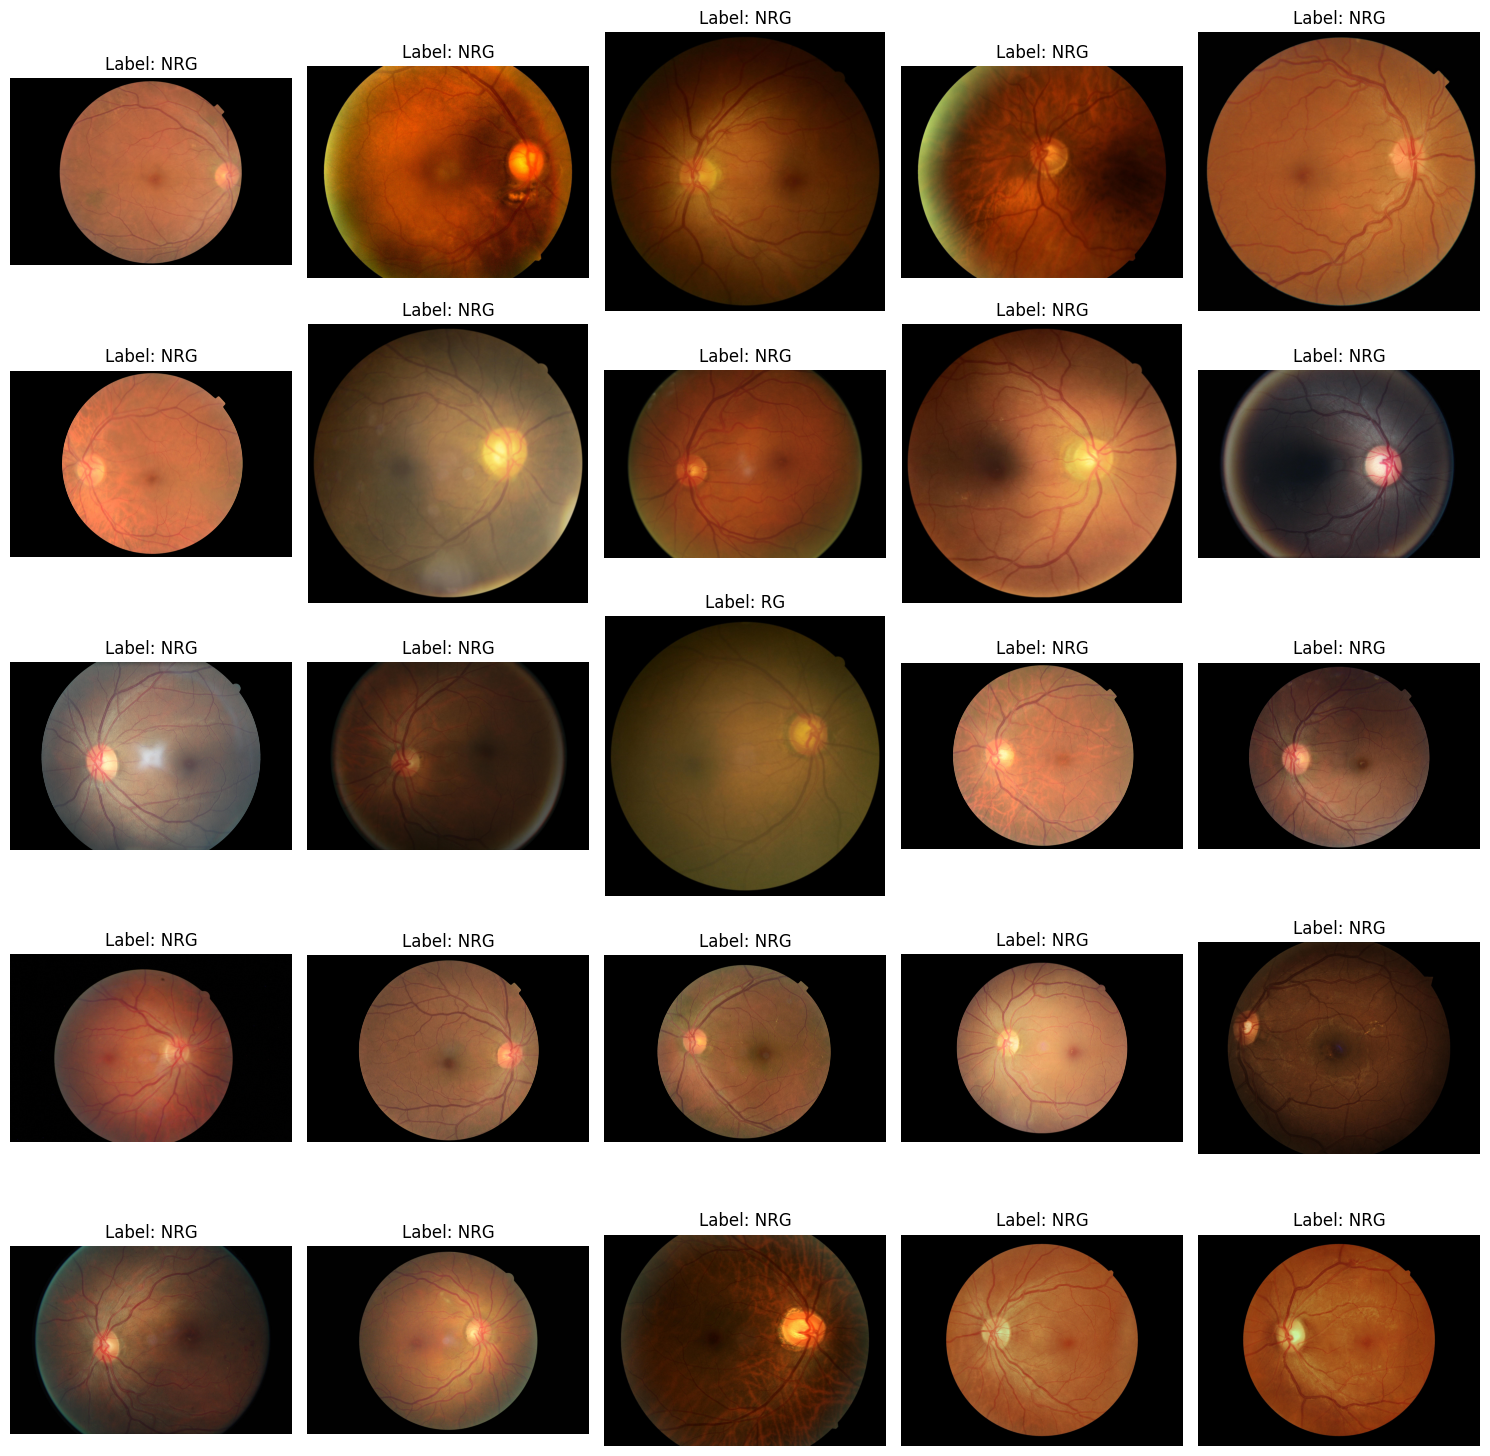

In [9]:
def plot_images_with_labels(folder_path, labels_df):
    """
    Plot images with their corresponding labels in a 5x5 grid.

    Parameters:
        folder_path (str): Path to the folder containing the images.
        labels_df (DataFrame): DataFrame containing image labels.
    """
    subplot_index = 1

    # Subplot grid
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

    # Iterate through the images folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".JPG"):
            image_name = os.path.splitext(filename)[0]


            label_row = labels_df.loc[labels_df['Eye ID'] == image_name]
            if not label_row.empty:
                label = label_row['Final Label'].values[0]

                # Plot the images with their labels
                image_path = os.path.join(folder_path, filename)
                img = mpimg.imread(image_path)
                row_index = (subplot_index - 1) // 5
                col_index = (subplot_index - 1) % 5
                axes[row_index, col_index].imshow(img)
                axes[row_index, col_index].set_title(f"Label: {label}")
                axes[row_index, col_index].axis('off')

                subplot_index += 1

                if subplot_index > 25:
                    break
            else:
                print(f"No label found for image: {filename}")


    plt.tight_layout()
    plt.show()

folder_path = "0"
labels_df = df
plot_images_with_labels(folder_path, labels_df)


* **NRG** - no referable glaucoma
* **RG** - referable glaucoma

## Making Train-Test split

In [10]:
# 1. Reading labels
labels_df = df

# 2. train, test, and validation splits
train_ratio = 0.7
test_ratio = 0.2
validation_ratio = 0.1

# 3. Iterate through the image folder
folder_path = "0"
for filename in os.listdir(folder_path):
    if filename.endswith(".JPG"):
        image_name = os.path.splitext(filename)[0]
        label_row = labels_df.loc[labels_df['Eye ID'] == image_name]
        if not label_row.empty:
            label = label_row['Final Label'].values[0]
            rand_num = random.random()
            if rand_num < train_ratio:
                split_folder = "train"
            elif rand_num < (train_ratio + test_ratio):
                split_folder = "test"
            else:
                split_folder = "validation"
            split_subfolder = os.path.join(split_folder, "NRG" if label == "NRG" else "RG")
            os.makedirs(split_subfolder, exist_ok=True)
            shutil.move(os.path.join(folder_path, filename), os.path.join(split_subfolder, filename))

            print(f"Image: {filename}, Label: {label}, Moved to: {split_subfolder}")
        else:
            print(f"No label found for image: {filename}")

Streaming output truncated to the last 5000 lines.
Image: TRAIN011919.JPG, Label: NRG, Moved to: test/NRG
Image: TRAIN004412.JPG, Label: NRG, Moved to: validation/NRG
Image: TRAIN011823.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN010065.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN007283.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN002352.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN000999.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN000265.JPG, Label: NRG, Moved to: test/NRG
Image: TRAIN010006.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN004839.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN001257.JPG, Label: NRG, Moved to: validation/NRG
Image: TRAIN016025.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN008711.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN005083.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN016339.JPG, Label: NRG, Moved to: train/NRG
Image: TRAIN006648.JPG, Label: NRG, Moved to: test/NRG
Image: TRAIN012997.JPG, Label: NRG, Moved to: 

# Data Augmentation

In [11]:
# Defining directories
train_dir = '/content/train'
test_dir = '/content/test'
val_dir = '/content/validation'

In [12]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images:")
train_augmented = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Validation images:")
val_augmented = val_datagen.flow_from_directory(val_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

print("Testing images:")
test_augmented = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

Training images:
Found 12115 images belonging to 2 classes.
Validation images:
Found 1724 images belonging to 2 classes.
Testing images:
Found 3542 images belonging to 2 classes.


# Model Building
> Using a CNN Model for Binary Classification

In [13]:
# Building the model

cnn_model = Sequential([
  Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=2,
                            padding="valid"),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(2),
  Flatten(),
  Dense(1, activation="sigmoid")
])

# Compile the model
cnn_model.compile(loss="binary_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

# Fit the model
model = cnn_model.fit(train_augmented,
                        epochs=5,
                        steps_per_epoch=0.2*len(train_augmented),
                        validation_data=val_augmented,
                        validation_steps=0.2*len(val_augmented))

Epoch 1/5
75/75 [==============================] - 157s 2s/step - loss: 0.1749 - accuracy: 0.9700 - val_loss: 0.1780 - val_accuracy: 0.9574
Epoch 2/5
75/75 [==============================] - 147s 2s/step - loss: 0.1604 - accuracy: 0.9626 - val_loss: 0.1460 - val_accuracy: 0.9688
Epoch 3/5
75/75 [==============================] - 143s 2s/step - loss: 0.1478 - accuracy: 0.9675 - val_loss: 0.2165 - val_accuracy: 0.9517
Epoch 4/5
75/75 [==============================] - 144s 2s/step - loss: 0.1392 - accuracy: 0.9696 - val_loss: 0.2053 - val_accuracy: 0.9517
Epoch 5/5
75/75 [==============================] - 143s 2s/step - loss: 0.1502 - accuracy: 0.9663 - val_loss: 0.1664 - val_accuracy: 0.9602


In [14]:
test_loss, test_accuracy = cnn_model.evaluate(test_augmented)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

111/111 [==============================] - 152s 1s/step - loss: 0.1530 - accuracy: 0.9641
Test Loss: 0.15300554037094116
Test Accuracy: 0.9641445279121399


In [15]:
y_test =test_augmented.classes
predictions = cnn_model.predict(test_augmented)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df2 = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df2.head()

111/111 [==============================] - 138s 1s/step


Actual  Prediction
0       0           0
1       0           0
2       0           0
3       0           0
4       0           0

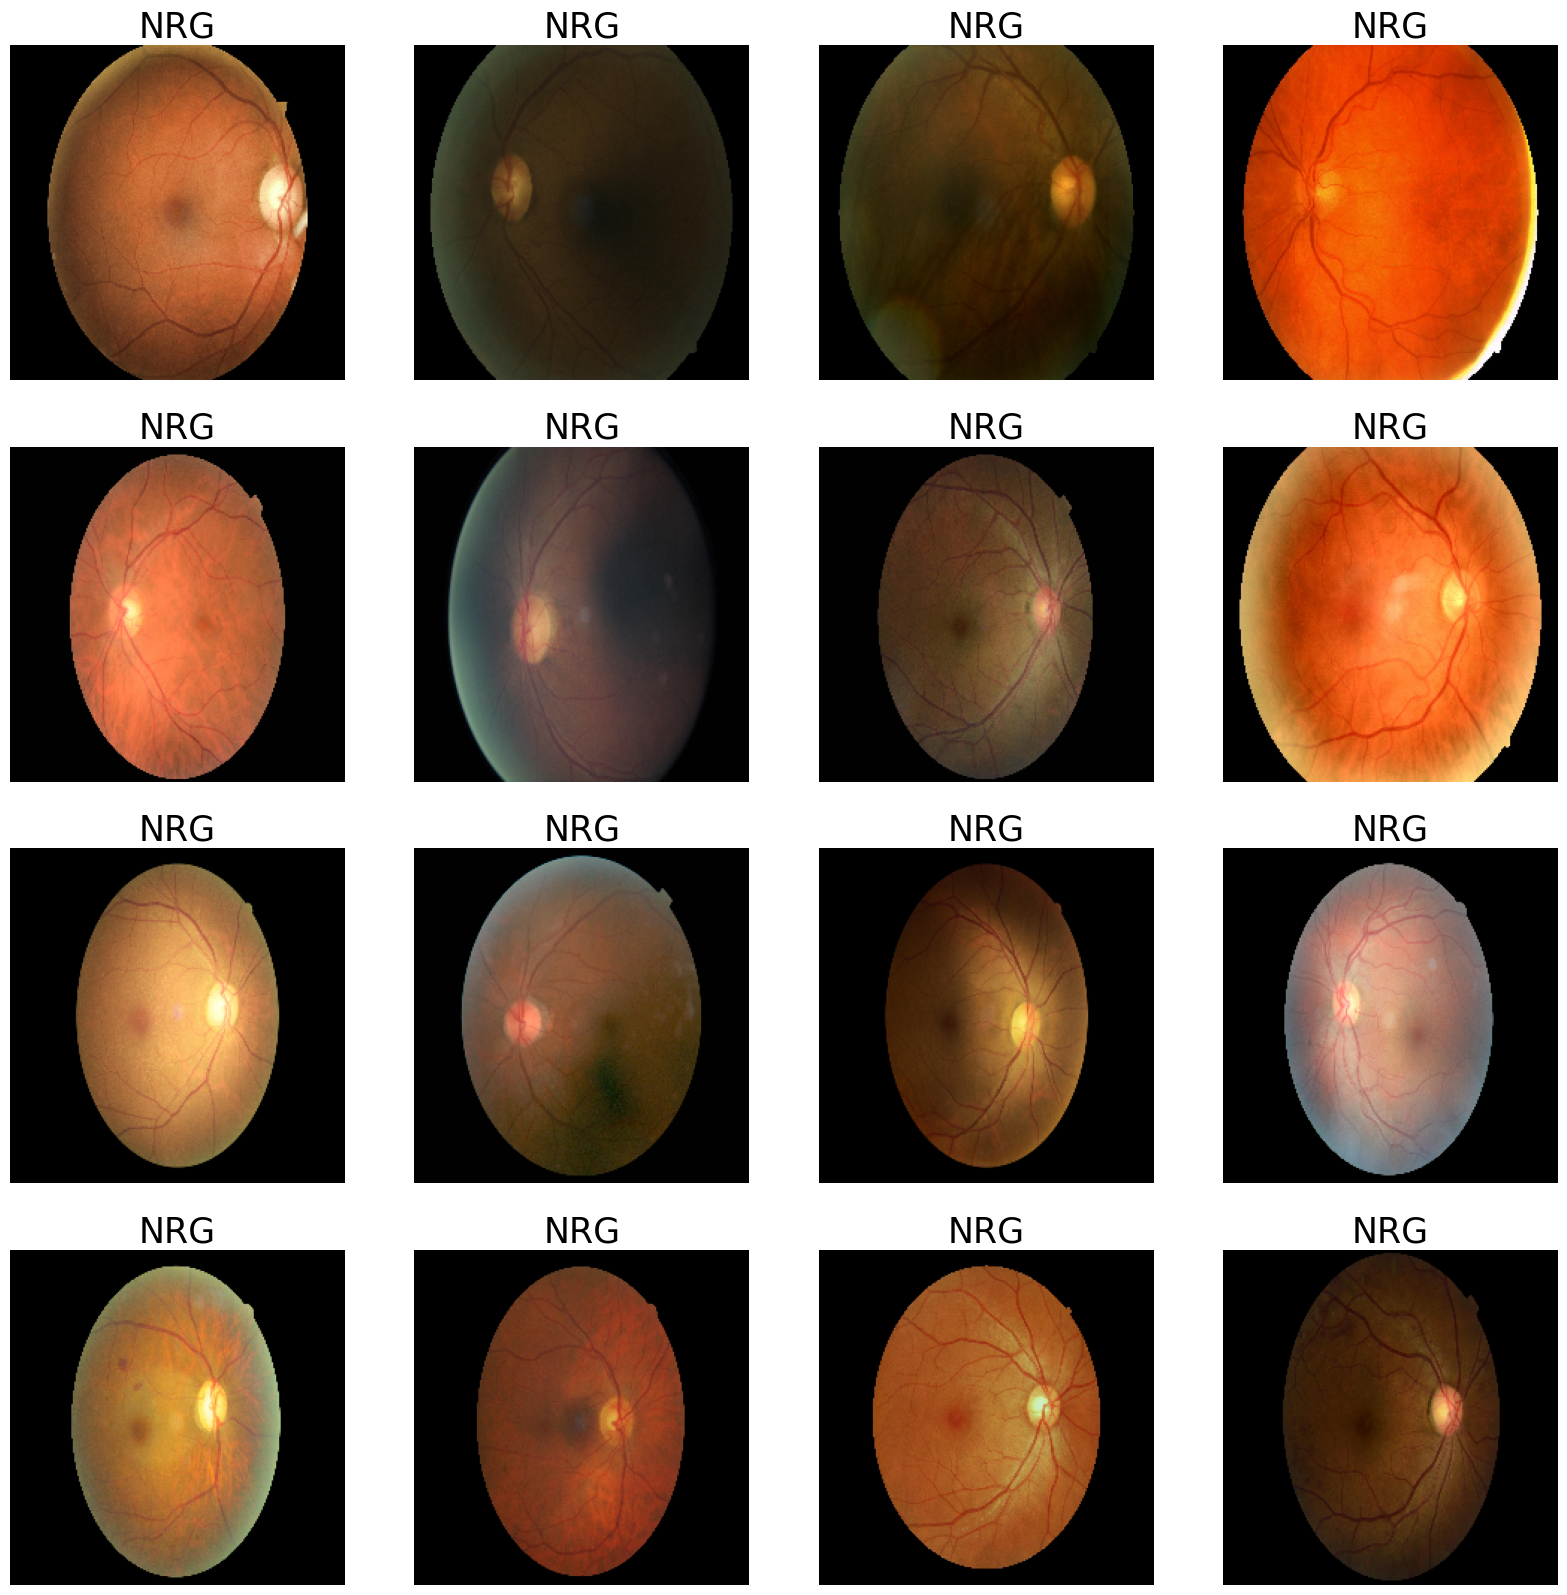

In [19]:
class_names=['NRG', 'RG']
batch = next(test_augmented)
images= batch[0]
plt.figure(figsize=(20,20))
for n in range(16):
    plt.subplot(4,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)